# Stock Price Forecasting using LSTM

Source https://medium.com/the-handbook-of-coding-in-finance/stock-prices-prediction-using-long-short-term-memory-lstm-model-in-python-734dd1ed6827

In [17]:
import math
import yfinance as yf 
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
plt.style.use('Solarize_Light2')

## Get the Data
Use yfinance to aquire the data

In [5]:
stock_name = 'AAPL'
stock_start_date = '2016-01-01'
stock_end_date = '2021-10-01'
stock_data = yf.download(stock_name, start=stock_start_date, end=stock_end_date)
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-12-31,26.752501,26.757500,26.205000,26.315001,24.199890,163649200
2016-01-04,25.652500,26.342501,25.500000,26.337500,24.220577,270597600
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.613625,223164000
2016-01-06,25.139999,25.592501,24.967501,25.174999,23.151518,273829600
2016-01-07,24.670000,25.032499,24.107500,24.112499,22.174416,324377600


Visualize the data as a graph

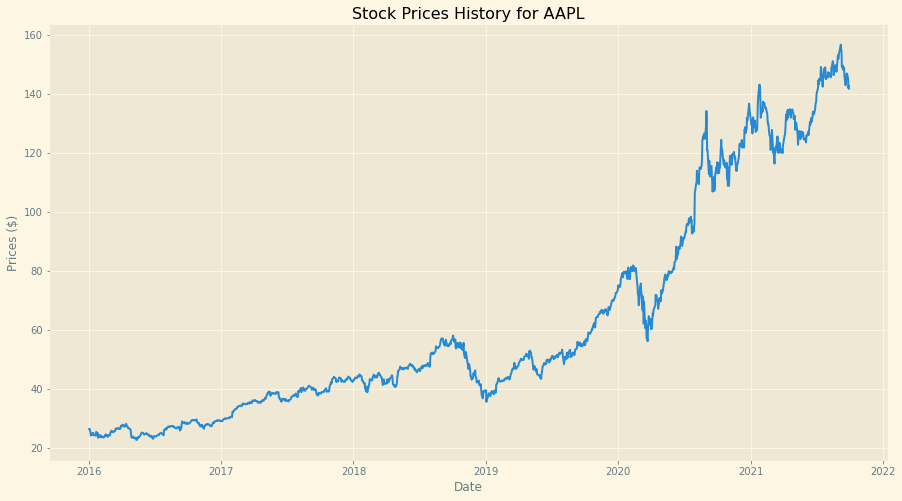

In [18]:
plt.figure(figsize=(15,8))
plt.title('Stock Prices History for ' + stock_name)
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.show()

## Preprocess the Data

### Training Set
1. Create a 80-20 split 
2. Normalize the data into values between 0 and 1
3. Reshape the data into values between -1 and 1

note: wouldnt tanh be better here ? 

In [16]:
close_price = stock_data['Close']
values = close_price.values
training_data_len = math.ceil(len(values) * 0.8)

scalar = MinMaxScaler(feature_range=(0, 1)) # Normalize the data, side note could apply sigmoid instead maybe ?? 
scaled_data = scalar.fit_transform(values.reshape(-1, 1))
training_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

4. Create a 60-days window of historical prices (i-60) as our feature data (x_train) and the following 60-days window as label date (y_train)
5. Convert data into numpy arrays

In [8]:
for i in range(60, len(training_data)):
    x_train.append(training_data[i-60:i, 0])
    y_train.append(training_data[i, 0])


# Convert the data to numpy arrays for tensorflow reasons 
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### Test set

In [9]:
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = values[training_data_len]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## Model
Create a LSTM model

In [10]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


## Training
Train the model

In [11]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=3, batch_size=1, verbose=1)

Epoch 1/3
1099/1099 [==============================] - 18s 15ms/step - loss: 8.3299e-04
Epoch 2/3
1099/1099 [==============================] - 17s 15ms/step - loss: 4.5314e-04
Epoch 3/3
1099/1099 [==============================] - 17s 16ms/step - loss: 2.1830e-04


Evaluate the model with rmse

In [12]:
predictions = model.predict(x_test)
predictions = scalar.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print(rmse)

23.089927673339844


## Visualize the result, i.e the forcast

C:\Users\ronih\AppData\Local\Temp\ipykernel_82440\3358919373.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


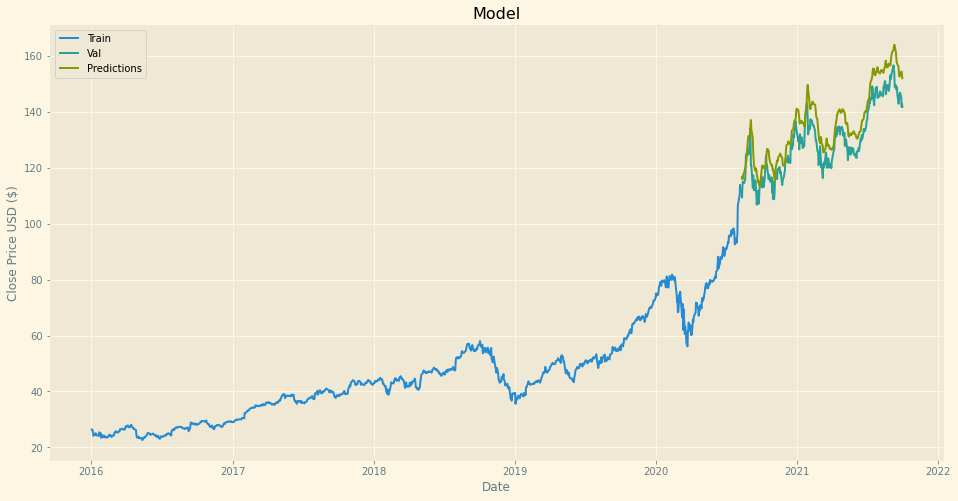

In [20]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='best')
plt.show()